# Модуль 3. Мультимодальные и мультизадачные модели. Часть 1.

Это первая часть домашней работы №3 "Реализация Visual Question Answering / Document Question Answering"

## Часть 1.Обучение модели для задачи Document Question Answering [2 балла]

**Цель:** отработать навыки работы с мультимодальностью на задаче Document Question Answering.

В этой части задания вам предстоит ознакомиться с обучением модели Document Question Answering. Вы можете пропустить эту часть и начать делать уже следующую, для них уже есть обученная готовая модель. Тут вам нужно лишь пройти по ноутбуку и посмотреть на процесс обучения. Он может занять продолжительное время.

---
**В каком виде прислать результат**.

Заполненный jupyter-notebook и графики обучения модели (можно прислать ссылку на wandblogger/mlflow)

**Ожидаемый результат**

В качестве результатов в этой части вам нужно представить обученную модели и показать результаты её работы, посчитав долю правильных ответов на вопросы.

# План решения

В решении я буду использовать код, представленный превподавателем. После обучения модели добавлю оценку модели на тестовом датасете. Также в обучение добавлю сохранения результатов на wandb (я сделала результаты публичными, доступ должен быть по ссылке ниже).


## Шаг 1 Загрузим библиотеки

Помимо упомянутой выше предварительной обработки, нам также необходимо добавить метки для модели. Для моделей xxxForQuestionAnswering в 🤗 Transformers метки состоят из start_positions и end_positions, указывающих, какой токен находится в начале, а какой токен — в конце ответа.

Начнем с этого. Определите вспомогательную функцию, которая может найти подсписок (ответ, разделенный на слова) в более крупном списке (списке слов).

Эта функция будет принимать на вход два списка:words_list и answer_list. Затем он будет перебирать words_list и проверять равно ли текущее слово в words_list (words_list[i]) первому слову в (answer_list[0]) и равен ли подсписок words_list, начинающийся с текущего слова и той же длины, что и answer_list списку response_list. Если это условие истинно, это означает, что совпадение найдено, и функция запишет совпадение, его начальный индекс (idx) и конечный индекс (idx + len(answer_list) - 1). Если найдено более одного совпадения, функция вернет только первое. Если совпадение не найдено, функция возвращает (None, 0, и 0).

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-7638rj8_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-7638rj8_
  Resolved https://github.com/facebookresearch/detectron2.git to commit 337ca3490fa7879ceeeadf6c2b73d67504ff4b4f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 11.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  2.0.0
detectron2: 0.6


In [3]:
!pip install -q transformers

In [4]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.8 MB/s eta 0:00:0000:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0


In [5]:
!pip install -q datasets

In [6]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 74 not upgraded.


## Шаг 2. Загрузим датасет и модель

Поля в датасете:

- id: идентификатор примера
- image: объект PIL.Image.Image, содержащий изображение документа.
- query: строка вопроса - вопрос, заданный на естественном языке, на нескольких языках.
- answers: список правильных ответов, предоставленных комментаторами-людьми.
- words и bounding_boxes: результаты OCR, которые мы здесь использовать не будем
- answer: ответ, соответствующий другой модели, которую мы здесь не будем использовать.

In [7]:
model_checkpoint = "microsoft/layoutlmv2-base-uncased"
batch_size = 8

In [8]:
from datasets import load_dataset
raw_datasets = load_dataset("nielsr/docvqa_1200_examples")
raw_datasets

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/nielsr--docvqa_1200_examples-747d27ee074c54e8/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'],
        num_rows: 200
    })
})

## Шаг 3. Предварительная обработка данных

Обрабатывать данные будем с помощью image processor.

В связи с ограничением на ресурсы обрабатывать данные буду не в полном объеме, а только определенную часть.

Обирать данные буду по длине, чтобы не превысить максимальную длину эмьеддингов модели (512).

In [9]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained(model_checkpoint)
image_processor = processor.image_processor

def get_ocr_words_and_boxes(examples):

  # get a batch of document images
  images = [image_file.convert("RGB") for image_file in examples['image']]
  questions = [query['en'] for query in examples['query']]
  answers = [answer[0] for answer in examples['answers']]


  # resize every image to 224x224 + apply tesseract to get words + normalized boxes
  encoded_inputs = image_processor(images)

  examples['image'] = encoded_inputs.pixel_values
  examples['words'] = encoded_inputs.words
  examples['boxes'] = encoded_inputs.boxes
  examples['question'] = questions
  examples['answers'] = answers


  return examples

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
sample_train_dataset = raw_datasets['train'].filter(lambda x: len(x["words"]) + len(x["query"]['en'].split()) < 512).shuffle(seed=3).select(range(500))
sample_test_dataset = raw_datasets['test'].filter(lambda x: len(x["words"]) + len(x["query"]['en'].split()) < 512).shuffle(seed=3).select(range(50))

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [11]:
train_with_ocr = sample_train_dataset.map(get_ocr_words_and_boxes, batched=True, batch_size=2,
                                    remove_columns = ['bounding_boxes', 'query', 'answer'])

test_with_ocr = sample_test_dataset.map(get_ocr_words_and_boxes, batched=True, batch_size=2,
                                    remove_columns = ['bounding_boxes', 'query', 'answer'])

test_with_ocr

  0%|          | 0/250 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

Dataset({
    features: ['id', 'image', 'answers', 'words', 'boxes', 'question'],
    num_rows: 50
})

In [12]:
# check whether words and normalized bounding boxes are added correctly
print(train_with_ocr[17]['words'])
print(train_with_ocr[17]['question'])
print(train_with_ocr[17]['answers'])

['NDA', '21-073/8-023', 'Page', '10', 'Table', '3', 'Glycemic', 'Parameters', 'in', 'a', '26-Week', 'Placebo-Controlled', '_', '_', 'Dose-Ranging', 'Study', 'ee', 'ACTOS', 'ACTOS', 'ACTOS', '45', 'mg', '30', 'mg', '45mg', 'Placebo', 'Once', 'Once', 'Once', 'Daily', 'Daily', 'Daily', 'Naive', 'to', 'Therapy', 'HbAte', '(%)', 'N=25', 'N=26', 'N=26', 'N=21', 'Screening', '(mean)', '3.3', '10.0', '9.5', '9.8', 'Baseline', '(mean)', '9.0', '3.9', '8.3', '10.0', 'Change', 'from', 'baseline', '(adjusted', 'mean*)', '0.6', '~0.8', '-0.6', '“18', 'Difference', 'frorn', 'placebo', '(adjusted', 'mean*}', '+14', '“1.3', '“2.6', 'FPG', '(mg/dL)', 'N=25,', 'N=26', 'N=Z6', 'Ne24', 'Screening', '(mean)', '223', '245', '239', '239', 'Baseline', '(mean)', '229', '251', '225', '235', 'Change', 'from', 'baseline', '(adjusted', 'mean*)', '16', '-37', '~44', '~64', 'Difference', 'from', 'placebo', '(adjusted', 'mean*)', '|', '-52', '~56', '-80', 'Previously', 'Treated', 'HbAd,', '(%)', 'N=54', 'N=53', 'N=59

Также необходимо добавить метки для модели. Для моделей xxxForQuestionAnswering в 🤗 Transformers метки состоят из start_positions и end_positions, указывающих, какой токен находится в начале, а какой токен — в конце ответа.

Начнем с этого. Определите вспомогательную функцию, которая может найти подсписок (ответ, разделенный на слова) в более крупном списке (списке слов).

Эта функция будет принимать на вход два списка:words_list и answer_list. Затем он будет перебирать words_list и проверять равно ли текущее слово в words_list (words_list[i]) первому слову в (answer_list[0]) и равен ли подсписок words_list, начинающийся с текущего слова и той же длины, что и answer_list списку response_list. Если это условие истинно, это означает, что совпадение найдено, и функция запишет совпадение, его начальный индекс (idx) и конечный индекс (idx + len(answer_list) - 1). Если найдено более одного совпадения, функция вернет только первое. Если совпадение не найдено, функция возвращает (None, 0, и 0).

Используя эту функцию, создадим еще одну для энкодинга батча.

In [13]:
# source: https://stackoverflow.com/a/12576755
def subfinder(words_list, answer_list):
    matches = []
    start_indices = []
    end_indices = []
    for idx, i in enumerate(range(len(words_list))):


        if words_list[i] == answer_list[0] and words_list[i:i+len(answer_list)] == answer_list:
            matches.append(answer_list)
            start_indices.append(idx)
            end_indices.append(idx + len(answer_list) - 1)
    if matches:
      return matches[0], start_indices[0], end_indices[0]
    else:
      return None, 0, 0

In [14]:
tokenizer = processor.tokenizer

In [15]:
def encode_dataset(examples, max_length=512):
    questions = examples["question"]
    words = examples["words"]
    boxes = examples["boxes"]
    answers = examples["answers"]

    # encode the batch of examples and initialize the start_positions and end_positions
    encoding = tokenizer(questions, words, boxes, max_length=max_length, padding="max_length", truncation=True)
    start_positions = []
    end_positions = []

    # loop through the examples in the batch
    for i in range(len(questions)):
        cls_index = encoding["input_ids"][i].index(tokenizer.cls_token_id)

        # find the position of the answer in example's words
        words_example = [word.lower() for word in words[i]]
        answer = answers[i]

        match, word_idx_start, word_idx_end = subfinder(words_example, answer.lower().split())

        if match:
            # if match is found, use `token_type_ids` to find where words start in the encoding
            token_type_ids = encoding["token_type_ids"][i]
            token_start_index = 0
            while token_type_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(encoding["input_ids"][i]) - 1
            while token_type_ids[token_end_index] != 1:
                token_end_index -= 1

            word_ids = encoding.word_ids(i)[token_start_index : token_end_index + 1]
            start_position = cls_index
            end_position = cls_index

            # loop over word_ids and increase `token_start_index` until it matches the answer position in words
            # once it matches, save the `token_start_index` as the `start_position` of the answer in the encoding
            for id in word_ids:
                if id == word_idx_start:
                    start_position = token_start_index
                else:
                    token_start_index += 1

            # similarly loop over `word_ids` starting from the end to find the `end_position` of the answer
            for id in word_ids[::-1]:
                if id == word_idx_end:
                    end_position = token_end_index
                else:
                    token_end_index -= 1

            start_positions.append(start_position)
            end_positions.append(end_position)

            #print("Verifying start position and end position:")
            #print("True answer:", answer)
            #s_position = start_positions[i]
            #e_position = end_positions[i]
            #reconstructed_answer = tokenizer.decode(encoding.input_ids[i][s_position:e_position+1])
            #print("Reconstructed answer:", reconstructed_answer)
            #print("-----------")

        else:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
            #print("Answer not found in context")
            #print("-----------")

    encoding["image"] = examples["image"]
    encoding["start_positions"] = start_positions
    encoding["end_positions"] = end_positions
    encoding['example_id'] = examples["id"]

    return encoding

In [16]:
from datasets import Features, Sequence, Value, Array2D, Array3D

# we need to define custom features
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'start_positions': Value(dtype='int64'),
    'end_positions': Value(dtype='int64'),
    'example_id': Value(dtype='string'),
})

encoded_train = train_with_ocr.map(encode_dataset, batched=True, batch_size = 2,
                                       remove_columns=train_with_ocr.column_names,
                                       features=features)

encoded_test = test_with_ocr.map(encode_dataset, batched=True, batch_size = 2,
                                       remove_columns=test_with_ocr.column_names,
                                       features=features)

  0%|          | 0/250 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [17]:
encoded_train.features

{'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'image': Array3D(shape=(3, 224, 224), dtype='int64', id=None),
 'start_positions': Value(dtype='int64', id=None),
 'end_positions': Value(dtype='int64', id=None),
 'example_id': Value(dtype='string', id=None)}

Посмотрим, как сработал энкодинг на одном примере

In [18]:
idx = 44
tokenizer.decode(encoded_train['input_ids'][idx], skip_special_token = True).split('[SEP]')[1].strip()

'executive summary, cont. o proposed experiments o risk assessment for patients : o are nongenotoxic rodent bladder tumorigens predictive of human risk?! o conclusions, o supplementary materials donfidential ~ subject to protective order tak - barond - 0000076 ; p5379°00006'

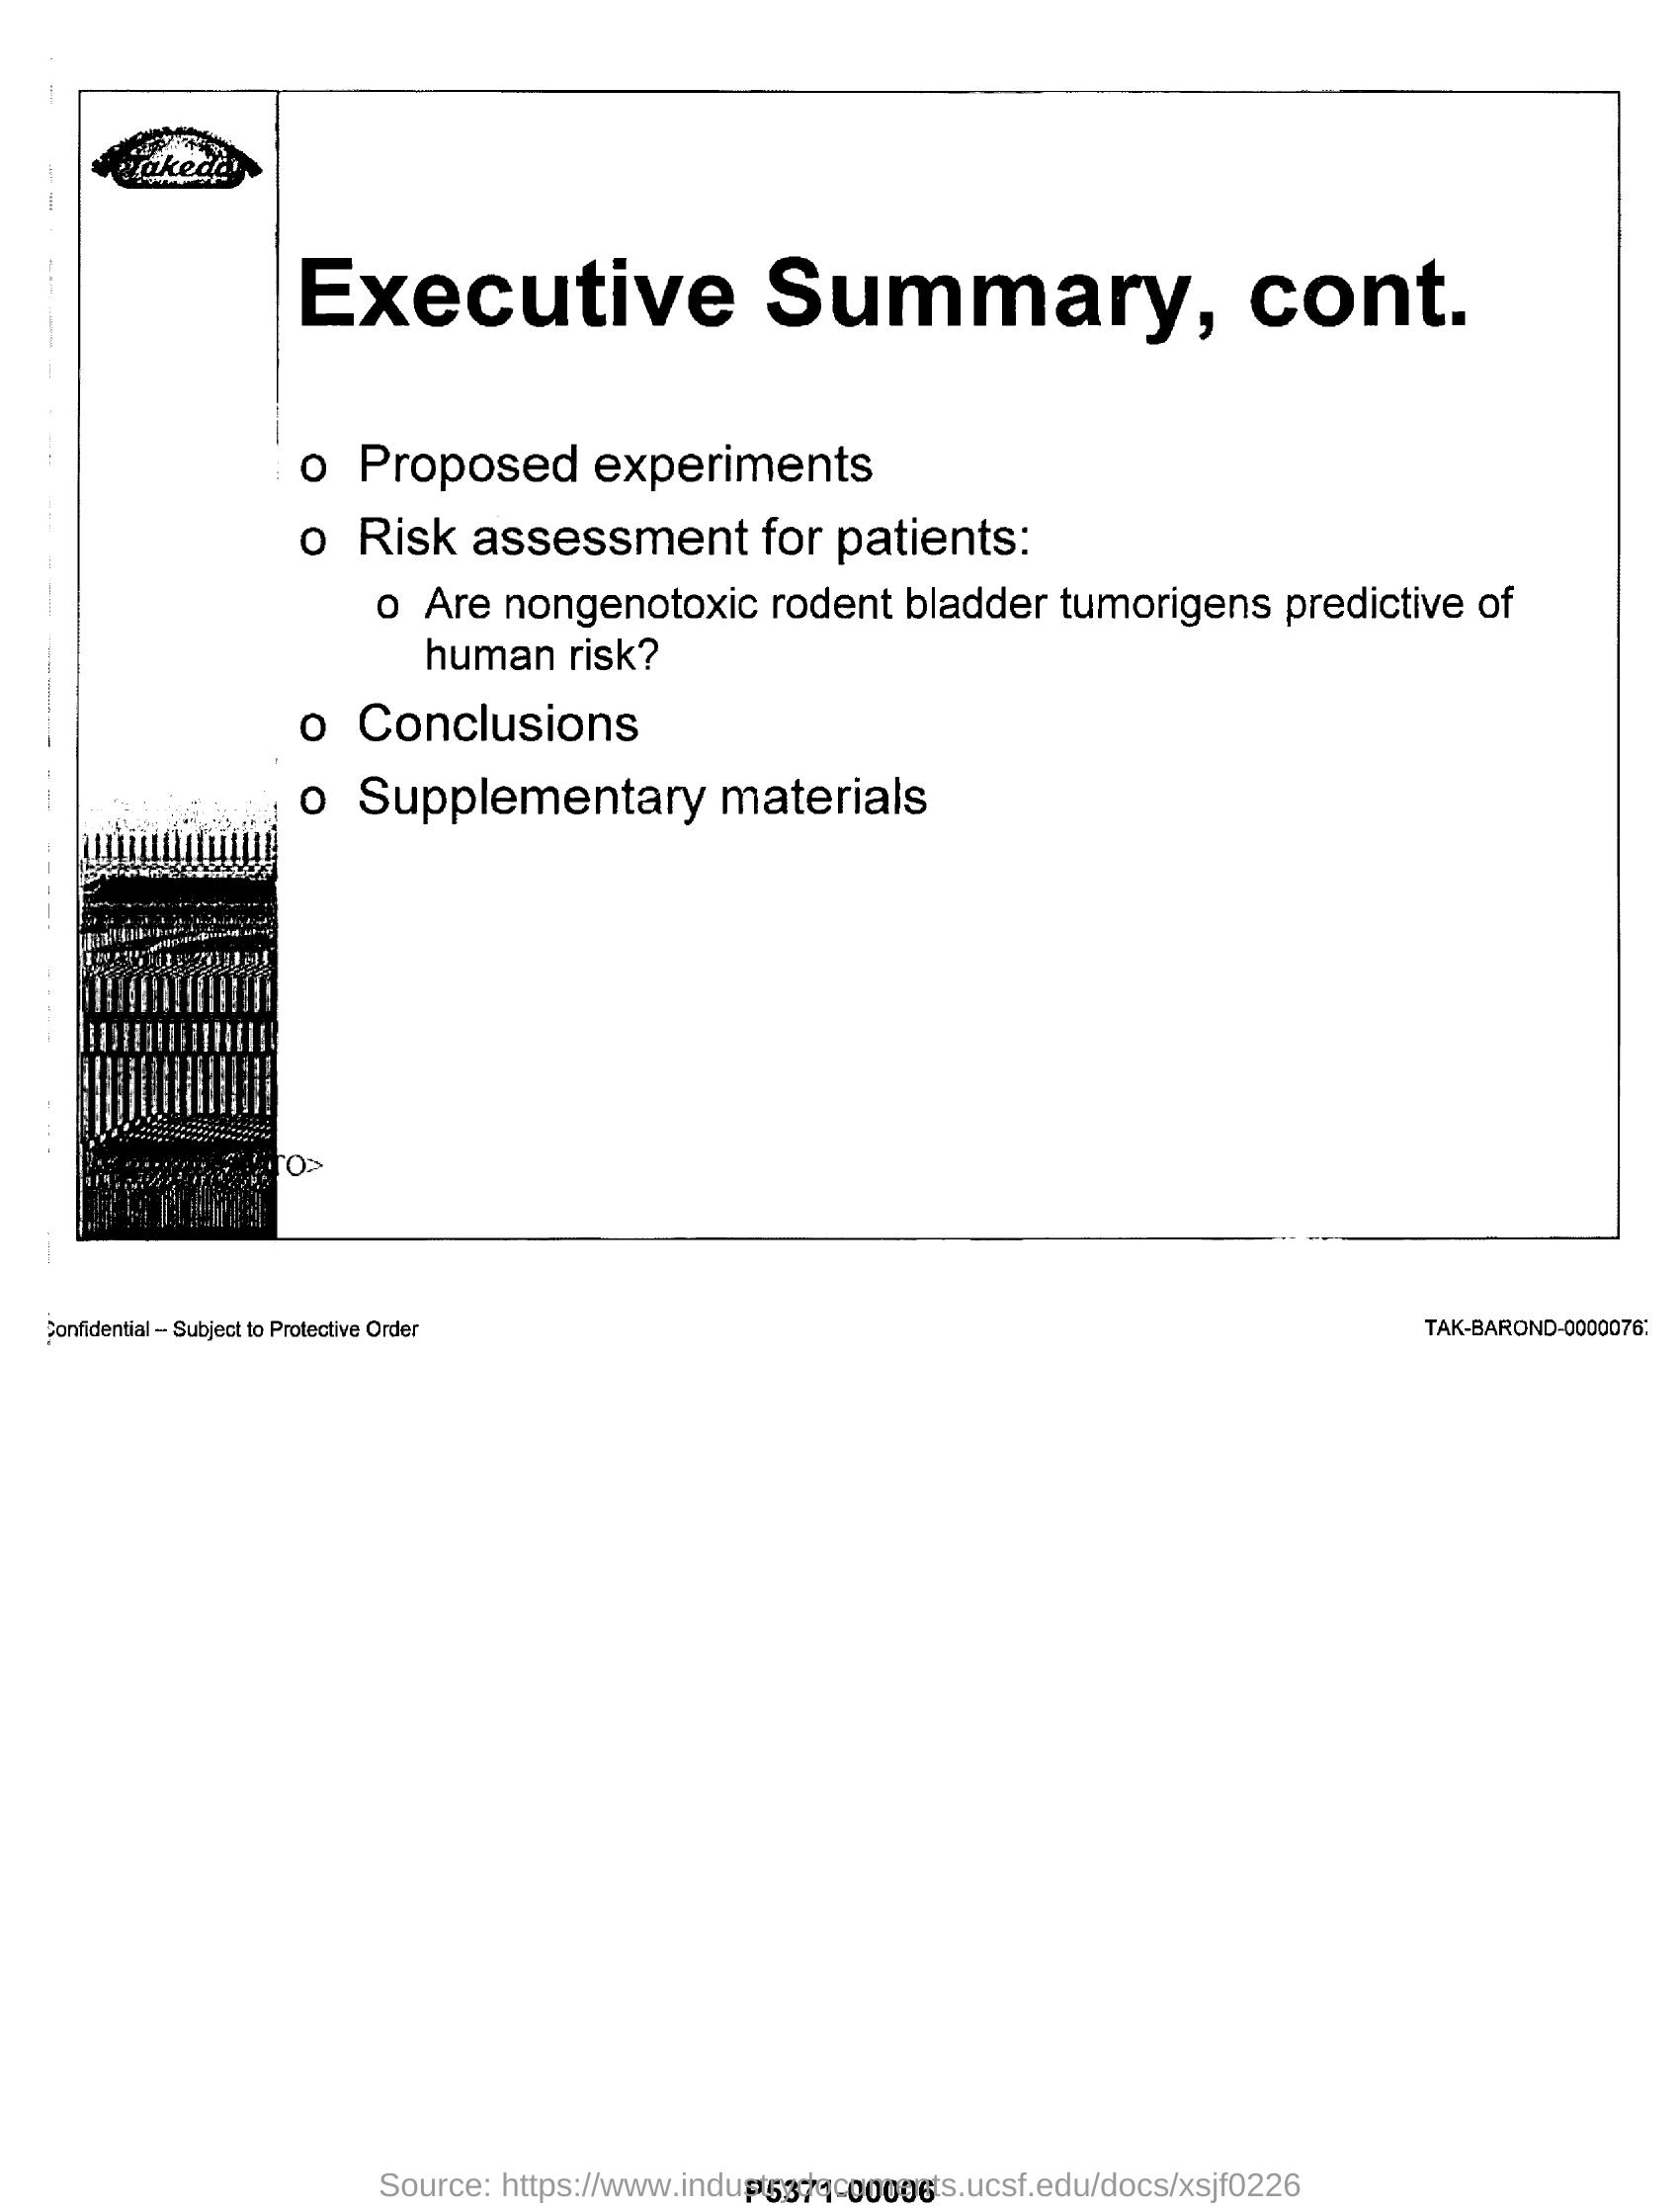

In [19]:
sample_train_dataset[idx]['image']

## Шаг 4. Обучение и оценка

Создаим функцию для оценки - воспользуемся готовой squad из библиотеки evaluate.

Обучать модель будут с помощью Trainer, заполним аргументы и после обучения оценим по выбранной метрике.

Сперва запущу обучение на 20 эпох, скорее всего модель переучится, запущу на более короткое кол-во, после которого будет расти loss.

In [20]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [21]:
import evaluate
metric = evaluate.load("squad")

In [22]:
from transformers import AutoModelForDocumentQuestionAnswering

model = AutoModelForDocumentQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'layoutlmv2.visual_segment_embedding', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [24]:
!pip install wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
import wandb
import os

os.environ['WANDB_PROJECT'] = 'exprmt2'
os.environ['WANDB_LOG_MODEL'] = 'true'

In [26]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [28]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='VQA',
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_strategy="no",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    remove_unused_columns=False,
    push_to_hub=False,
    fp16=True,
    report_to="wandb"
)

In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=processor,

)

trainer.train()

wandb: Currently logged in as: shakhovak1981 (shakhovak). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,4.305352
2,No log,4.029062
3,No log,3.645410
4,No log,3.593691
5,No log,3.459785
6,No log,3.190772
7,No log,2.994805
8,3.139400,3.014170
9,3.139400,3.095117
10,3.139400,3.063428


TrainOutput(global_step=630, training_loss=2.8603593129960316, metrics={'train_runtime': 924.1607, 'train_samples_per_second': 5.41, 'train_steps_per_second': 0.682, 'total_flos': 2699126077440000.0, 'train_loss': 2.8603593129960316, 'epoch': 10.0})

После 8-10 эпохи модель начинате сильно переобучаться и растет Validation Loss, поэтому в финальном варианте решения оставляю всего 10 эпох.
Дальше посмотрю на метрику обычно используемую в QA задачах - squad метрика. Она включает как требуемое в задании exact match, так и F1. Не ожидаю хороших результатов, так как обучалась модель не небольшом кол-ве данных и стала быстро переобчаться. 

In [30]:
wandb.finish()

eval/loss,█▇▄▄▃▂▁▁▂▁
eval/runtime,▂▁█▂▂▁▂▁▁▂
eval/samples_per_second,▇█▁▇▇▇▇██▇
eval/steps_per_second,▇█▁▇▇▇▇██▇
train/epoch,▁▂▃▃▄▅▆▆▆▇██
train/global_step,▁▂▃▃▄▅▆▆▆▇██
train/learning_rate,▁
train/loss,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [31]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):

    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["words"]


        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            #offsets = features[feature_index]["offset_mapping"]
            predicted_start_idx = int(start_logit.argmax(-1).item())
            predicted_end_idx = int(end_logit.argmax(-1).item())
            if predicted_end_idx > predicted_start_idx:
                    answer = context[predicted_start_idx:predicted_end_idx+1]
                    if type(answer) != 'list':
                      answer = ' '.join(answer)
                    answers.append({"id": str(example_id), "prediction_text":answer})
            else:
              answers.append({"id": str(example_id), "prediction_text":''})


    theoretical_answers = [{"id": str(ex["id"]), "answers": {'text':ex["answers"][0],
                                                        'answer_start':[ex["answer"]['start']]}, } for ex in examples]
    current_metric = metric.compute(predictions=answers, references=theoretical_answers)

    return current_metric, theoretical_answers, answers

In [32]:
import collections
predictions, labels, _ = trainer.predict(encoded_test)
start_logits, end_logits = predictions


current_metric, theoretical_answers, answers = compute_metrics(start_logits, end_logits, encoded_test, sample_test_dataset)

  0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
current_metric

{'exact_match': 48.0, 'f1': 0.051282051282051294}

Да, метрика совсем не радует (правильный ответ всего на 1 вопрос из 50:(). Посмотрим, какие ответы выдала модель на вопросы и эталонные ответы.

In [34]:
texts_together = []
for i in theoretical_answers:
  for j in answers:
    if i['id'] == j['id']:
      texts_together.append((i['answers']['text'], j['prediction_text']))
texts_together

[('ITC Limited', 'in the biscuit'),
 ('Essenza Di Wills, Fiama Di Wills, Vivel and Superia', ''),
 ('10:00 - 11:30 AM', ''),
 ('62272', ''),
 ('questions and answers', ''),
 ('Responsible Luxury', ''),
 ('public schools of ponca city, oklahoma', 'March 22, 1921 Place'),
 ('February 24', ''),
 ('proprietary cellulose acetate web', ''),
 ('MAJOR STRATEGIC RESEARCH PROGRAMS',
  'study which: Program complete-209t for product optimization among 1.'),
 ('candyman', ''),
 ('1.0', ''),
 ('Carol A. Tozzi, Ph.D.', ''),
 ('ITC Limited', ''),
 ('four', ''),
 ('Consumer Dynamics GPC', ''),
 ('Classmate and Paperkraft', ''),
 ('international union of nutritional sciences', 'take place in the CONGRESS'),
 ('12', ''),
 ('Menopausal Health Publication Management',
  'Menopausal Health Publication Management June 13, 2001 10:00 -11:30 AM, Conference Room #555-6B page 4 of 6'),
 ('5', ''),
 ('KOOLS', ''),
 ('70', ''),
 ('Aim', ''),
 ('July 26, 2000', ''),
 ('mint-o', ''),
 ('Maria Shulleeta', 'the RL pr

В большинтсве случаев - модель предсказывала end_index < start_index, поэтому ответ пустой. Где все-таки индексы предсказаны в нужном порядке, сам ответ выглядит совсем невпопад, всего несколько предложений, где более-менее взята правильная последовательность текста. 

Поэтому эту модель сохранять не буду, использую ее только для решения подзадачи 2 ниже, в последующих подзадачах буду использовать предобученную модель на VQA с Hugging Face и буду выполнять их в отдельном ноутбуке.

## [2 балла] Добавить модель переводчика

У вас уже есть готовая модель, которая может по картинке отвечать на текстовые запросы к картинке. Ваша цель --- обобщить эту модель на русский язык, добавив модель переводчик, которая будет переводить запрос на русском языке в запрос на английском языке и передавать его модели. За основу вы можете взять языковую модель (например, https://huggingface.co/Helsinki-NLP/opus-mt-ru-en). Альтернативой может стать реализация функции, делающий api вызов, к приложению переводчика (например, https://libretranslate.com/).

---

**Ожидаемый результат**

В качестве результата в этой секции вам нужно предоставить функции, которые делают перевод с русского на английского и делает инференс модели DocVQA и выводит ответ на русском языке. (В качестве примеров вопросов, можете использовать данные из датасета)

## План решения

Для решения буду использовать pipeline, в который добавлю как обученную модель, так и 2 модели переводчика

In [35]:
import torch
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

На примере одного изображения в тестовом датасете посмотрим, как работают пайплайны.

In [36]:
from transformers import pipeline

nlp = pipeline(task =  "document-question-answering",
    model=model, tokenizer=tokenizer, image_processor=image_processor, device = device)


In [37]:
example = raw_datasets['test'][99]
example.keys()

dict_keys(['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'])

In [38]:
nlp(image = example['image'], question = example['query']['en'], device = 0)

[{'score': 0.017187364399433136, 'answer': 'Kong)', 'start': 74, 'end': 74}]

In [39]:
example['answer']

{'match_score': 1.0,
 'matched_text': 'Philip Morris Super Lights',
 'start': 490,
 'text': 'Philip Morris Super Lights'}

Ожидаемо, модель дала неправильный ответ :(, в любом случае попробуем включить его в общий пайплайн в 2-х видах, вопрос и ответ -  на английском и вопрос и ответ - на русском.


In [40]:
ru_en = pipeline("translation", model="Helsinki-NLP/opus-mt-ru-en")
en_ru = pipeline("translation", model="Helsinki-NLP/opus-mt-en-ru")

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [41]:
ru_en('Привет! Меня зовут Катя и я живу в Москве')[0]['translation_text']

'My name is Katya and I live in Moscow.'

In [42]:
en_ru('Hello! How are you? I am from Moscow.')

[{'translation_text': 'Я из Москвы.'}]

In [43]:
def image_recognition_translation(image, question, qu_language = 'EN'):
    if qu_language == 'RU':
        print(f'Your question: {question}')
        question = ru_en(question)[0]['translation_text']
        answer =  nlp(image, question)[0]['answer']
        answer = en_ru(answer)[0]['translation_text']
    else:
        answer =  nlp(image, question)[0]['answer']
        print(f'Your question: {question}')
    
    print('Your answer is below:')
    
    return answer


In [44]:
image_recognition_translation(example['image'], example['query']['en'])

Your question: full form of PM super lights
Your answer is below:


'Kong)'

In [45]:
image_recognition_translation(image = example['image'], question = 'полная форма PM супер света', qu_language = 'RU')

Your question: полная форма PM супер света
Your answer is below:


'(Конг)'

## Финальные выводы

Интересно, что модель дала разные ответы на тот же самый вопрос, сыграл скорее всего мой перевод. В цклом использование pipeline очень ускоряет и облегчает инференс обученных моделей.
Следующие задания я сделаю в отдельном ноутбуке и буду уже использовать предобученную модель на VQA с Hugging Face, так как моя модель очень мало обучалась в связи с недостатком времени и ресурсов.